**Goal**: 

Determine if Hassan transform renders some (CT) texture of firstorder features independent of GL discretization which leads to a reduction of the feature space dimensionality.

[Hassan supplementary matreial](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-28895-9/MediaObjects/41598_2018_28895_MOESM1_ESM.pdf)

**NOTE**
* Image voxels are 1 mm$^3$.

In [1]:
import os
import re
import nrrd

from ioutil import sample_paths

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ICC_THRESH = 0.8

In [3]:
path_to_ct = './../../data_source/images/ct_removed_broken_slices/'
path_to_ct_masks = './../../data_source/images/masks_removed_broken_slices_ct_size/'

path_firstoder_features = './../../data_source/to_analysis/removed_broken_slices/firstorder_removed_broken_slices.csv'
path_texture_features = './../../data_source/to_analysis/removed_broken_slices/texture_removed_broken_slices.csv'

path_transf_features = './../../data_source/to_analysis/removed_broken_slices/hassan_all_features_removed_broken_slices.csv'

# Get number of GL

In [4]:
# NOTE: 
# * term `equispaced gray levels`.
# * the voxel intensities (gray levels) within the VOI are resampled to 2^N number of bins, where N 
#   ranges from 3 to 8.

# Bin widhts for Z-scored CT stacks.
width32 = 0.5787627551020408
width64 = 0.2893813775510204
width128 = 0.1446906887755102

# NOTE: Read from other image directory if not calc. bins for
# original images.
path_ct_stacks = sample_paths(path_to_ct, path_to_ct_masks, target_format='nrrd')

gl_32bins = np.zeros(len(path_ct_stacks))
gl_64bins = np.zeros(len(path_ct_stacks))
gl_128bins = np.zeros(len(path_ct_stacks))


idx = []
for num, ct_path in enumerate(path_ct_stacks):
    
    fname = os.path.basename(ct_path['Image'])
    idx_num = re.findall(r'\d+', fname.split('.')[0])[0]
    idx.append(int(idx_num))
    
    image, _ = nrrd.read(ct_path['Image'])
    mask, _ = nrrd.read(ct_path['Mask'])
    
    _cropped = image * mask
    cropped = _cropped[_cropped != 0]
        
    # NOTE: Z-scoring for CT texture features.
    cropped = (cropped - np.mean(cropped)) / (np.std(cropped) + + 1e-10)
    
    data = cropped.ravel()
    
    # Binning operation as conducted in PyRadiomics.
    minimum = min(data)
    maximum = max(data)

    low_32_bound = minimum - (minimum % width32)
    low_64_bound = minimum - (minimum % width64)
    low_128_bound = minimum - (minimum % width128)

    high_32_bound = maximum + 2 * width32
    high_64_bound = maximum + 2 * width64
    high_128_bound = maximum + 2 * width128

    bin_32_edges = np.arange(low_32_bound, high_32_bound, width32)
    bin_64_edges = np.arange(low_64_bound, high_64_bound, width64)
    bin_128_edges = np.arange(low_128_bound, high_128_bound, width128)
    
    gl_32bins[num] = np.size(bin_32_edges)
    gl_64bins[num] = np.size(bin_64_edges)
    gl_128bins[num] = np.size(bin_128_edges)

In [5]:
gl_32bins.shape, gl_64bins.shape, gl_128bins.shape

((196,), (196,), (196,))

In [6]:
clinical_features = pd.read_csv('./../../data_source/to_analysis/clinical_params.csv', index_col=0)
pet_params = pd.read_csv('./../../data_source/to_analysis/pet_params.csv', index_col=0)

clinical_features = clinical_features.loc[idx, :]
pet_params = pet_params.loc[idx, :]

clinical_features.shape, pet_params.shape

((196, 42), (196, 3))

In [7]:
# The average number of bins per GL discretization for the CURRENT images.
np.mean(gl_32bins), np.mean(gl_64bins), np.mean(gl_128bins)

(33.25, 63.494897959183675, 123.97448979591837)

In [8]:
# https://github.com/cosanlab/nltools/blob/master/nltools/data/brain_data.py
# https://www.aliquote.org/cours/2012_biomed/biblio/Shrout1979.pdf
def icc(X):
    """Calculate intraclass correlation coefficient (ICC). 
    
    Reference: 
        Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
        assessing rater reliability. Psychological bulletin, 86(2), 420.
    
    Args:
        X (array-like): Data matrix with observations on rows
            and measurements on columns.

    Returns:
        (float): Intraclass correlation coefficient.
                
    """
    n, k = np.shape(X)

    # Degrees of Freedom.
    dfc = k - 1
    dfe = (n - 1) * (k - 1)
    dfr = n - 1

    # Sum Square Total.
    mean_X = np.mean(X)
    SST = ((X - mean_X) ** 2).sum()

    # Create the design matrix for the different levels:
    # * Sessions.
    d = np.kron(np.eye(k), np.ones((n, 1)))  
    # * Subjects.
    d0 = np.tile(np.eye(n), (k, 1))  
    D = np.hstack([d, d0])

    # Sum Square Error.
    predicted_X = np.dot(
        np.dot(
            np.dot(
                D, np.linalg.pinv(np.dot(D.T, D))), D.T
            ), 
            X.flatten('F')
        )
    residuals = X.flatten('F') - predicted_X
    SSE = np.sum(residuals ** 2)
    MSE = SSE / dfe

    # Sum square column effect (between colums).
    SSC = np.sum((np.mean(X, 0) - mean_X) ** 2) * n
    MSC = SSC / dfc / n

    # Sum Square subject effect (between rows/subjects).
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    ICC = (MSR - MSE) / (MSR + (k - 1) * MSE)
    
    return ICC

In [9]:
firstorder = pd.read_csv(path_firstoder_features, index_col=0)
texture = pd.read_csv(path_texture_features, index_col=0)
features = pd.concat((firstorder, texture), axis=1)
features.head()

,CT_original_firstorder_10Percentile,CT_original_firstorder_90Percentile,CT_original_firstorder_Energy,CT_original_firstorder_Entropy_32bins,CT_original_firstorder_Entropy_64bins,CT_original_firstorder_Entropy_128bins,CT_original_firstorder_InterquartileRange,CT_original_firstorder_Kurtosis,CT_original_firstorder_Maximum,CT_original_firstorder_Mean,...,PET_original_ngtdm_Coarseness_128bins,PET_original_ngtdm_Complexity_32bins,PET_original_ngtdm_Complexity_64bins,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins
2,1064.131380,1116.375669,1.934609e+10,1.598086,2.422321,3.378726,23.744564,59.893869,1450.980316,1086.596504,...,0.000554,0.332260,2.875649,49.308852,0.000127,0.000164,0.001203,0.060466,0.214173,0.297980
4,972.027466,1183.041657,1.149213e+10,3.115232,4.083211,5.068944,79.044404,8.933352,1414.363699,1086.186295,...,0.001349,3.740105,14.209499,67.042138,0.004490,0.004617,0.006914,0.024249,0.091105,0.388307
5,1030.239139,1177.917830,1.989521e+10,2.694620,3.642433,4.622903,45.224022,14.831983,1763.283818,1104.664236,...,0.000810,2.453277,15.646650,106.093147,0.000985,0.000963,0.002301,0.039365,0.193554,0.592523
8,1028.577020,1085.938888,7.735412e+10,1.507373,2.414556,3.339893,22.494850,55.850257,1534.148775,1053.427788,...,0.000127,2.153056,11.631694,174.011183,0.000500,0.000441,0.001784,0.024303,0.133040,0.282213
10,1054.821012,1099.248341,1.240511e+10,1.369524,2.148839,3.076923,17.745937,46.402736,1364.937514,1072.696565,...,0.001227,0.564743,3.452748,36.475226,0.000115,0.000414,0.001741,0.096332,0.245306,0.538985


In [10]:
features.shape

(196, 494)

In [11]:
CT_texture = features.filter(regex='CT')
CT_texture.head()

,CT_original_firstorder_10Percentile,CT_original_firstorder_90Percentile,CT_original_firstorder_Energy,CT_original_firstorder_Entropy_32bins,CT_original_firstorder_Entropy_64bins,CT_original_firstorder_Entropy_128bins,CT_original_firstorder_InterquartileRange,CT_original_firstorder_Kurtosis,CT_original_firstorder_Maximum,CT_original_firstorder_Mean,...,CT_original_ngtdm_Coarseness_128bins,CT_original_ngtdm_Complexity_32bins,CT_original_ngtdm_Complexity_64bins,CT_original_ngtdm_Complexity_128bins,CT_original_ngtdm_Contrast_32bins,CT_original_ngtdm_Contrast_64bins,CT_original_ngtdm_Contrast_128bins,CT_original_ngtdm_Strength_32bins,CT_original_ngtdm_Strength_64bins,CT_original_ngtdm_Strength_128bins
2,1064.131380,1116.375669,1.934609e+10,1.598086,2.422321,3.378726,23.744564,59.893869,1450.980316,1086.596504,...,0.000554,0.332260,2.875649,49.308852,0.000127,0.000164,0.001203,0.060466,0.214173,0.297980
4,972.027466,1183.041657,1.149213e+10,3.115232,4.083211,5.068944,79.044404,8.933352,1414.363699,1086.186295,...,0.001349,3.740105,14.209499,67.042138,0.004490,0.004617,0.006914,0.024249,0.091105,0.388307
5,1030.239139,1177.917830,1.989521e+10,2.694620,3.642433,4.622903,45.224022,14.831983,1763.283818,1104.664236,...,0.000810,2.453277,15.646650,106.093147,0.000985,0.000963,0.002301,0.039365,0.193554,0.592523
8,1028.577020,1085.938888,7.735412e+10,1.507373,2.414556,3.339893,22.494850,55.850257,1534.148775,1053.427788,...,0.000127,2.153056,11.631694,174.011183,0.000500,0.000441,0.001784,0.024303,0.133040,0.282213
10,1054.821012,1099.248341,1.240511e+10,1.369524,2.148839,3.076923,17.745937,46.402736,1364.937514,1072.696565,...,0.001227,0.564743,3.452748,36.475226,0.000115,0.000414,0.001741,0.096332,0.245306,0.538985


In [12]:
# Hassan found 17 features with trend varying according to GL discr. 

# Ng is the number of discrete gray levels in the image.

# Feature definitions implemented by Hassan et al. were compared to the feature definitions 
# implemented in the PyRadiomics Python package.

# GLCM features normalized by the number of gray levels:
# * Entropy (found! named joint entropy in pyrad)
# * Diff. entropy (found!)
# * Sum entropy (found!)
# * Contrast (found!)
# * Mean (NOT found!)
# * Sum Variance (NOT found! deprecated in pyrad)
# * Difference Variance (found! try out, but DIFFERENT seems to be formula in pyrad)
# * Sum Average (found!)
# * Difference Average (found! try out, but DIFFERENT seems to be formula in pyrad)
# * Dissimilarity (NOT found!)


# GLRLM features normalized by the number of gray levels.
# * GLNU (found!)
# * HGRE (found!) 
# * SRHGE (found!)

# NGTDM features normalized by the number of gray levels.
# * Contrast (found!)
# * Complexity (found!)
# * Texture strength (found! names strength only in pyrad)

# GLSZM features normalized by the number of gray levels.
# * HIE (NOT found!)

# Intercorrelation Coefficient of all features

In [13]:
col_regexes = np.unique([('_').join(col.split('_')[:-1]) for col in features.columns])

#assert col_regexes.size * 3 == features.columns.size

all_feat_icc = np.zeros(col_regexes.size)
for num, label in enumerate(col_regexes):
    all_feat_icc[num] = icc(features.filter(regex=label).values)
    
sum(all_feat_icc >= ICC_THRESH)

24

In [14]:
list(col_regexes[all_feat_icc >= ICC_THRESH])

['CT_original_firstorder_Entropy',
 'CT_original_glcm_Correlation',
 'CT_original_glcm_Imc1',
 'CT_original_glcm_MCC',
 'CT_original_gldm_GrayLevelNonUniformity',
 'CT_original_gldm_SmallDependenceLowGrayLevelEmphasis',
 'CT_original_glrlm_GrayLevelNonUniformityNormalized',
 'CT_original_glrlm_RunLengthNonUniformityNormalized',
 'CT_original_glrlm_RunPercentage',
 'CT_original_glrlm_ShortRunEmphasis',
 'CT_original_glszm_LargeAreaHighGrayLevelEmphasis',
 'CT_original_glszm_ZoneEntropy',
 'PET_original_firstorder_Entropy',
 'PET_original_glcm_Correlation',
 'PET_original_glcm_Imc1',
 'PET_original_glcm_MCC',
 'PET_original_gldm_GrayLevelNonUniformity',
 'PET_original_gldm_SmallDependenceLowGrayLevelEmphasis',
 'PET_original_glrlm_GrayLevelNonUniformityNormalized',
 'PET_original_glrlm_RunLengthNonUniformityNormalized',
 'PET_original_glrlm_RunPercentage',
 'PET_original_glrlm_ShortRunEmphasis',
 'PET_original_glszm_LargeAreaHighGrayLevelEmphasis',
 'PET_original_glszm_ZoneEntropy']

In [15]:
df_icc_all_feats = pd.DataFrame(
    all_feat_icc[all_feat_icc >= ICC_THRESH],
    index=col_regexes[all_feat_icc >= ICC_THRESH],
    columns=['Score']
)
df_icc_all_feats.shape

(24, 1)

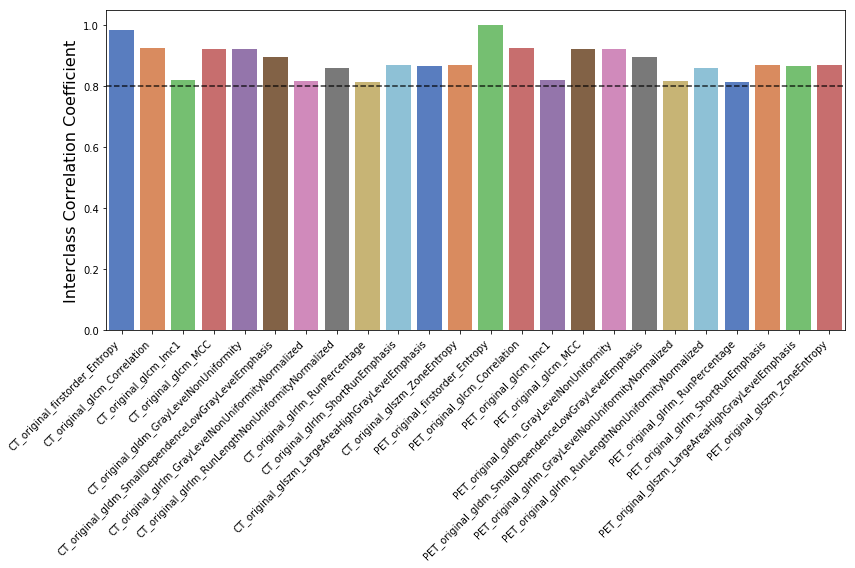

In [16]:
# Plotting features with ICC > ICC_THRESH.
plt.figure(figsize=(12, 8))
sns.barplot(
    x=df_icc_all_feats.index, 
    y='Score', 
    data=df_icc_all_feats, 
    #palette='PuBu',
    palette='muted',
)
plt.ylabel('Interclass Correlation Coefficient', fontsize='16')
plt.xticks(
    np.arange(df_icc_all_feats.index.size), df_icc_all_feats.index, rotation=45, ha='right'
)
plt.axhline(y=ICC_THRESH, linestyle='--', alpha=0.8, color='k')#'darkblue')
plt.tight_layout()
plt.savefig(
    './icc_original_images.png'
)

# Hassan Transform of Selected Features

In [17]:
hassan_transforms = {
    'CT_original_glcm_DifferenceEntropy': lambda Ng, feature: feature / np.log(Ng ** 2),
    'CT_original_glcm_JointEntropy': lambda Ng, feature: feature / np.log(Ng ** 2),
    'CT_original_glcm_SumEntropy': lambda Ng, feature: feature / np.log(Ng ** 2),
    'CT_original_glcm_Contrast': lambda Ng, feature: feature / (Ng ** 2),
    'CT_original_glcm_DifferenceVariance': lambda Ng, feature: feature / (Ng ** 2),
    'CT_original_glcm_SumAverage': lambda Ng, feature: feature / Ng,
    'CT_original_glcm_DifferenceAverage': lambda Ng, feature: feature / Ng,
    'CT_original_glrlm_GrayLevelNonUniformity': lambda Ng, feature: feature * Ng,
    'CT_original_glrlm_HighGrayLevelRunEmphasis': lambda Ng, feature: feature / (Ng ** 2),
    'CT_original_glrlm_ShortRunHighGrayLevelEmphasis': lambda Ng, feature: feature / (Ng ** 2),
    'CT_original_ngtdm_Contrast': lambda Ng, feature: feature / Ng,
    'CT_original_ngtdm_Complexity': lambda Ng, feature: feature / (Ng ** 3),
    'CT_original_ngtdm_Strength': lambda Ng, feature: feature / (Ng ** 2),
}

In [18]:
# NB: Bins widths for transformation should correspond to 
# feature extraction protocol (e.g. Z-score transf. CT scans).
gl_bins = [gl_32bins, gl_64bins, gl_32bins]

icc_orig_feat = np.zeros(len(hassan_transforms.keys()))
icc_norm_feat = np.zeros(len(hassan_transforms.keys()))
for num, (key, transform) in enumerate(hassan_transforms.items()):
    
    X_orig = CT_texture.filter(regex=key).values
    icc_orig_feat[num] = icc(X_orig)
    
    X_norm = np.zeros_like(X_orig)    
    for _num, gl_bin in enumerate(gl_bins):
        X_norm[:, _num] = transform(
            gl_bin, features.loc[:, features.columns[num]]
        )
    icc_norm_feat[num] = icc(X_norm)

In [19]:
df_icc_orig_feat = pd.DataFrame(icc_orig_feat, index=hassan_transforms.keys(), columns=['Score'])
df_icc_orig_feat['Kind'] = ['Original'] * len(hassan_transforms.keys())

df_icc_norm_feat = pd.DataFrame(icc_norm_feat, index=hassan_transforms.keys(), columns=['Score'])
df_icc_norm_feat['Kind'] = ['Transformed'] * len(hassan_transforms.keys())

df_icc = pd.concat((df_icc_orig_feat, df_icc_norm_feat), axis=0)
df_icc.head()

,Score,Kind
CT_original_glcm_DifferenceEntropy,0.789770,Original
CT_original_glcm_JointEntropy,0.754210,Original
CT_original_glcm_SumEntropy,0.755770,Original
CT_original_glcm_Contrast,0.318157,Original
CT_original_glcm_DifferenceVariance,0.325077,Original


"plt.savefig(\n    './hassan_icc_original_images.png'\n    #'./hassan_icc_removed_broken_images.png'\n)"

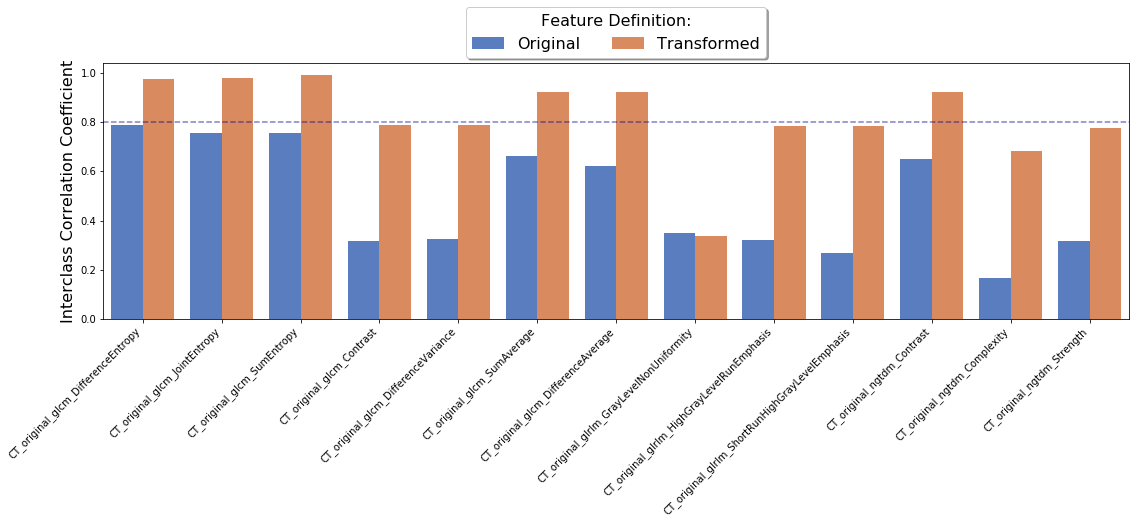

In [20]:
# Plotting original and transformed CT texture features.
plt.figure(figsize=(16, 8))
sns.barplot(
    x=df_icc.index, 
    y='Score', 
    hue='Kind', 
    data=df_icc, 
    palette='muted',
)
plt.ylabel('Interclass Correlation Coefficient', fontsize='16')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=ICC_THRESH, linestyle='--', alpha=0.5, color='darkblue')
plt.legend(
    fontsize=16,
    title='Feature Definition:', title_fontsize=16,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.25),
    ncol=2, 
    fancybox=True, 
    shadow=True
)
plt.tight_layout()
"""plt.savefig(
    './hassan_icc_original_images.png'
    #'./hassan_icc_removed_broken_images.png'
)"""

# Remove GL Discr. Duplicates from Dataset

In [21]:
df_icc.index.size, np.unique(df_icc.index).size

(26, 13)

In [22]:
stable_features = np.unique(
    np.concatenate((df_icc_all_feats.index, df_icc.index))
)
len(stable_features)

37

In [23]:
list(stable_features)

['CT_original_firstorder_Entropy',
 'CT_original_glcm_Contrast',
 'CT_original_glcm_Correlation',
 'CT_original_glcm_DifferenceAverage',
 'CT_original_glcm_DifferenceEntropy',
 'CT_original_glcm_DifferenceVariance',
 'CT_original_glcm_Imc1',
 'CT_original_glcm_JointEntropy',
 'CT_original_glcm_MCC',
 'CT_original_glcm_SumAverage',
 'CT_original_glcm_SumEntropy',
 'CT_original_gldm_GrayLevelNonUniformity',
 'CT_original_gldm_SmallDependenceLowGrayLevelEmphasis',
 'CT_original_glrlm_GrayLevelNonUniformity',
 'CT_original_glrlm_GrayLevelNonUniformityNormalized',
 'CT_original_glrlm_HighGrayLevelRunEmphasis',
 'CT_original_glrlm_RunLengthNonUniformityNormalized',
 'CT_original_glrlm_RunPercentage',
 'CT_original_glrlm_ShortRunEmphasis',
 'CT_original_glrlm_ShortRunHighGrayLevelEmphasis',
 'CT_original_glszm_LargeAreaHighGrayLevelEmphasis',
 'CT_original_glszm_ZoneEntropy',
 'CT_original_ngtdm_Complexity',
 'CT_original_ngtdm_Contrast',
 'CT_original_ngtdm_Strength',
 'PET_original_firstord

In [24]:
# ERROR:

# Remove duplicates of stable features.
for col in stable_features:
    try:
        feat_dupls = features.filter(regex=col)
        col_values = np.copy(feat_dupls.values[:, 0])
        features.drop(feat_dupls.columns, inplace=True, axis=1)
        features[col] = col_values
    except:
        pass

In [25]:
# Have first order and texture features. Must combine with PET parameters, clinical variables and shape features.
X = pd.concat((clinical_features, features, pet_params), axis=1)
np.shape(X)

(196, 464)

In [28]:
X.to_csv(path_transf_features)